# Download
https://figshare.com/projects/Tabula_Muris_Transcriptomic_characterization_of_20_organs_and_tissues_from_Mus_musculus_at_single_cell_resolution/27733

10X Single-cell RNA-seq data from microfluidic emulsion (v2)

SS2 Single-cell RNA-seq data from Smart-seq2 sequencing of FACS sorted cells (v2)

# Preprocess

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.4.6 numpy==1.19.2 scipy==1.6.2 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.7.0


In [2]:
tissue = "Marrow"

data_path = "data_TM/" + tissue

if not os.path.exists(data_path):
    os.makedirs(data_path)

path_SS2 = "./Raw_data_TabulaMuris/FACS"
path_10X = "./Raw_data_TabulaMuris/droplet"

meta_SS2 = pd.read_csv("./Raw_data_TabulaMuris/annotations_facs.csv", keep_default_na=False)
meta_10X = pd.read_csv("./Raw_data_TabulaMuris/annotations_droplet.csv", keep_default_na=False)

# Read SS2 cell-by-gene counts
adata_SS2 = sc.read_csv(os.path.join(path_SS2, "%s-counts.csv" % tissue)).transpose()
ERCC_idx = pd.Series(adata_SS2.var.index).str.startswith('ERCC')
cell_idx = adata_SS2.obs.index.isin(meta_SS2[(meta_SS2.cell_ontology_class != 0) & 
                                             (meta_SS2.cell_ontology_class != "")].cell)
adata_SS2 = adata_SS2[cell_idx, -ERCC_idx]

# Read 10X cell-by-gene counts
channels = sorted(set(meta_10X[meta_10X.tissue == tissue].channel))
for i, channel in enumerate(channels):
    if i == 0:
        adata_10X = sc.read_10x_mtx(path_10X + '/%s-%s/' % (tissue, channel), 
                                    var_names='gene_symbols',cache=False)
        adata_10X.obs.index = channel + "_" + adata_10X.obs.index
        adata_10X.obs.index = adata_10X.obs.index.map(lambda x: x[:-2])
        cell_idx = adata_10X.obs.index.isin(meta_10X[(meta_10X.cell_ontology_class != 0) &
                                                     (meta_10X.cell_ontology_class != "")].cell)
        adata_10X = adata_10X[cell_idx, :]
    else:
        tmp = sc.read_10x_mtx(path_10X + '/%s-%s/' % (tissue, channel), 
                              var_names='gene_symbols',cache=False)
        tmp.obs.index = channel + "_" + tmp.obs.index
        tmp.obs.index = tmp.obs.index.map(lambda x: x[:-2])
        cell_idx = tmp.obs.index.isin(meta_10X[(meta_10X.cell_ontology_class != 0) &
                                               (meta_10X.cell_ontology_class != "")].cell)
        adata_10X = adata_10X.concatenate(tmp[cell_idx, :], index_unique=None)

celltype_SS2 = meta_SS2[meta_SS2.cell.isin(adata_SS2.obs.index)][["cell", "cell_ontology_class"]].set_index("cell")
celltype_SS2["method"] = "SS2"
celltype_10X = meta_10X[meta_10X.cell.isin(adata_10X.obs.index)][["cell", "cell_ontology_class"]].set_index("cell")
celltype_10X["method"] = "10X"
meta = pd.concat([celltype_SS2, celltype_10X]).rename(columns={"cell_ontology_class": "celltype"})
meta.to_pickle(os.path.join(data_path, "meta_raw.pkl"))

sc.pp.filter_cells(adata_SS2, min_genes=200)
sc.pp.filter_genes(adata_SS2, min_cells=3)
sc.pp.filter_cells(adata_10X, min_genes=200)
sc.pp.filter_genes(adata_10X, min_cells=3)

meta = pd.read_pickle(os.path.join(data_path, "meta_raw.pkl"))
meta = meta.loc[list(adata_SS2.obs.index) + list(adata_10X.obs.index), ]
meta.to_pickle(os.path.join(data_path, "meta.pkl"))

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Trying to set attribute `.obs` of view, copying.
filtered out 5019 genes that are detected in less than 3 cells
filtered out 9282 genes that are detected in less than 3 cells


# Integration using Portal

In [3]:
import portal

# Specify the GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Create a folder for saving results
result_path = "./result_TM"
if not os.path.exists(result_path):
    os.makedirs(result_path)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Finding highly variable genes...


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)


Normalizing and scaling...


/home/jzhaoaz/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Dimensionality reduction via PCA...
Begining time:  Thu Mar 17 17:11:00 2022
step 0, loss_D=13.500851, loss_GAN=3.212498, loss_AE=395.496582, loss_cos=57.002136, loss_LA=303.115417
step 200, loss_D=2.124192, loss_GAN=4.836796, loss_AE=11.139089, loss_cos=6.221899, loss_LA=3.838384
step 400, loss_D=1.813991, loss_GAN=4.152006, loss_AE=5.993252, loss_cos=4.237713, loss_LA=1.838591
step 600, loss_D=1.682961, loss_GAN=4.147172, loss_AE=5.021276, loss_cos=4.054947, loss_LA=1.361614
step 800, loss_D=1.522764, loss_GAN=4.478311, loss_AE=3.881725, loss_cos=3.463865, loss_LA=0.936189
Ending time:  Thu Mar 17 17:11:24 2022
Training takes 24.73 seconds
Begining time:  Thu Mar 17 17:11:24 2022
Ending time:  Thu Mar 17 17:11:24 2022
Evaluating takes 0.06 seconds
UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Thu Mar 17 17:11:24 2022 Finding Nearest 

/home/jzhaoaz/.conda/envs/scUNIT/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Thu Mar 17 17:11:35 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


... storing 'celltype' as categorical
... storing 'method' as categorical


Thu Mar 17 17:12:03 2022 Finished embedding


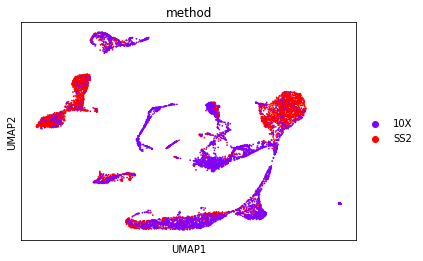

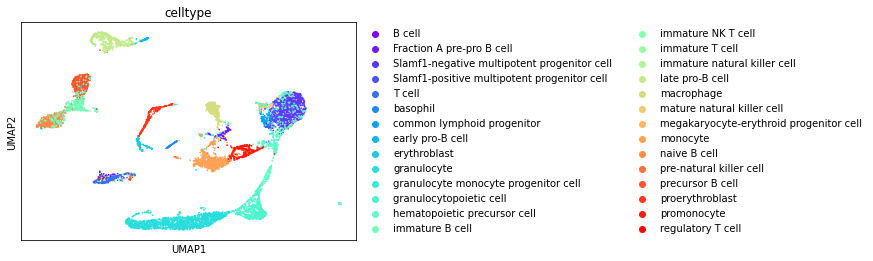

In [4]:
model = portal.model.Model(training_steps=1000, lambdacos=30.0)
model.preprocess(adata_SS2, adata_10X) # perform preprocess and PCA
model.train() # train the model
model.eval() # get integrated latent representation of cells

portal.utils.plot_UMAP(model.latent, meta, colors=["method", "celltype"], save=True, result_path=result_path)

In [5]:
# repreduce figure in paper
import umap
from sklearn import preprocessing
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib as mpl

meta['celltype'] = meta['celltype'].str.capitalize()

meta = pd.read_pickle(os.path.join("data_TM/" + tissue, "meta.pkl"))
meta['celltype'] = meta['celltype'].str.capitalize()
le = preprocessing.LabelEncoder()
le.fit(sorted(set(meta["method"])))
label = le.fit_transform(meta["method"].values)
colours = ListedColormap(["tab:blue", "tab:orange"])

rgb_10 = [i for i in get_cmap('Set3').colors]
rgb_20 = [i for i in get_cmap('tab20').colors]
rgb_20b = [i for i in get_cmap('tab20b').colors]
rgb2hex_10 = [mpl.colors.rgb2hex(color) for color in rgb_10]
rgb2hex_20 = [mpl.colors.rgb2hex(color) for color in rgb_20]
rgb2hex_20b = [mpl.colors.rgb2hex(color) for color in rgb_20b]
rgb2hex_20b_new = [rgb2hex_20b[i] for i in [0, 3, 4, 7, 8, 11, 12, 15, 16, 19]]
rgb2hex = rgb2hex_20 + rgb2hex_20b_new

le2 = preprocessing.LabelEncoder()
le2.fit(sorted(set(meta["celltype"])))
label2 = le.fit_transform(meta["celltype"].values)
colours2 = ListedColormap(rgb2hex)

reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=True)

embedding = reducer.fit_transform(model.latent)

n_cells = embedding.shape[0]
if n_cells >= 15000:
    size = 120000 / n_cells
else:
    size = 8

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Thu Mar 17 17:12:06 2022 Finding Nearest Neighbors
Thu Mar 17 17:12:06 2022 Building RP forest with 10 trees
Thu Mar 17 17:12:06 2022 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Thu Mar 17 17:12:07 2022 Finished Nearest Neighbor Search
Thu Mar 17 17:12:08 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Mar 17 17:12:35 2022 Finished embedding


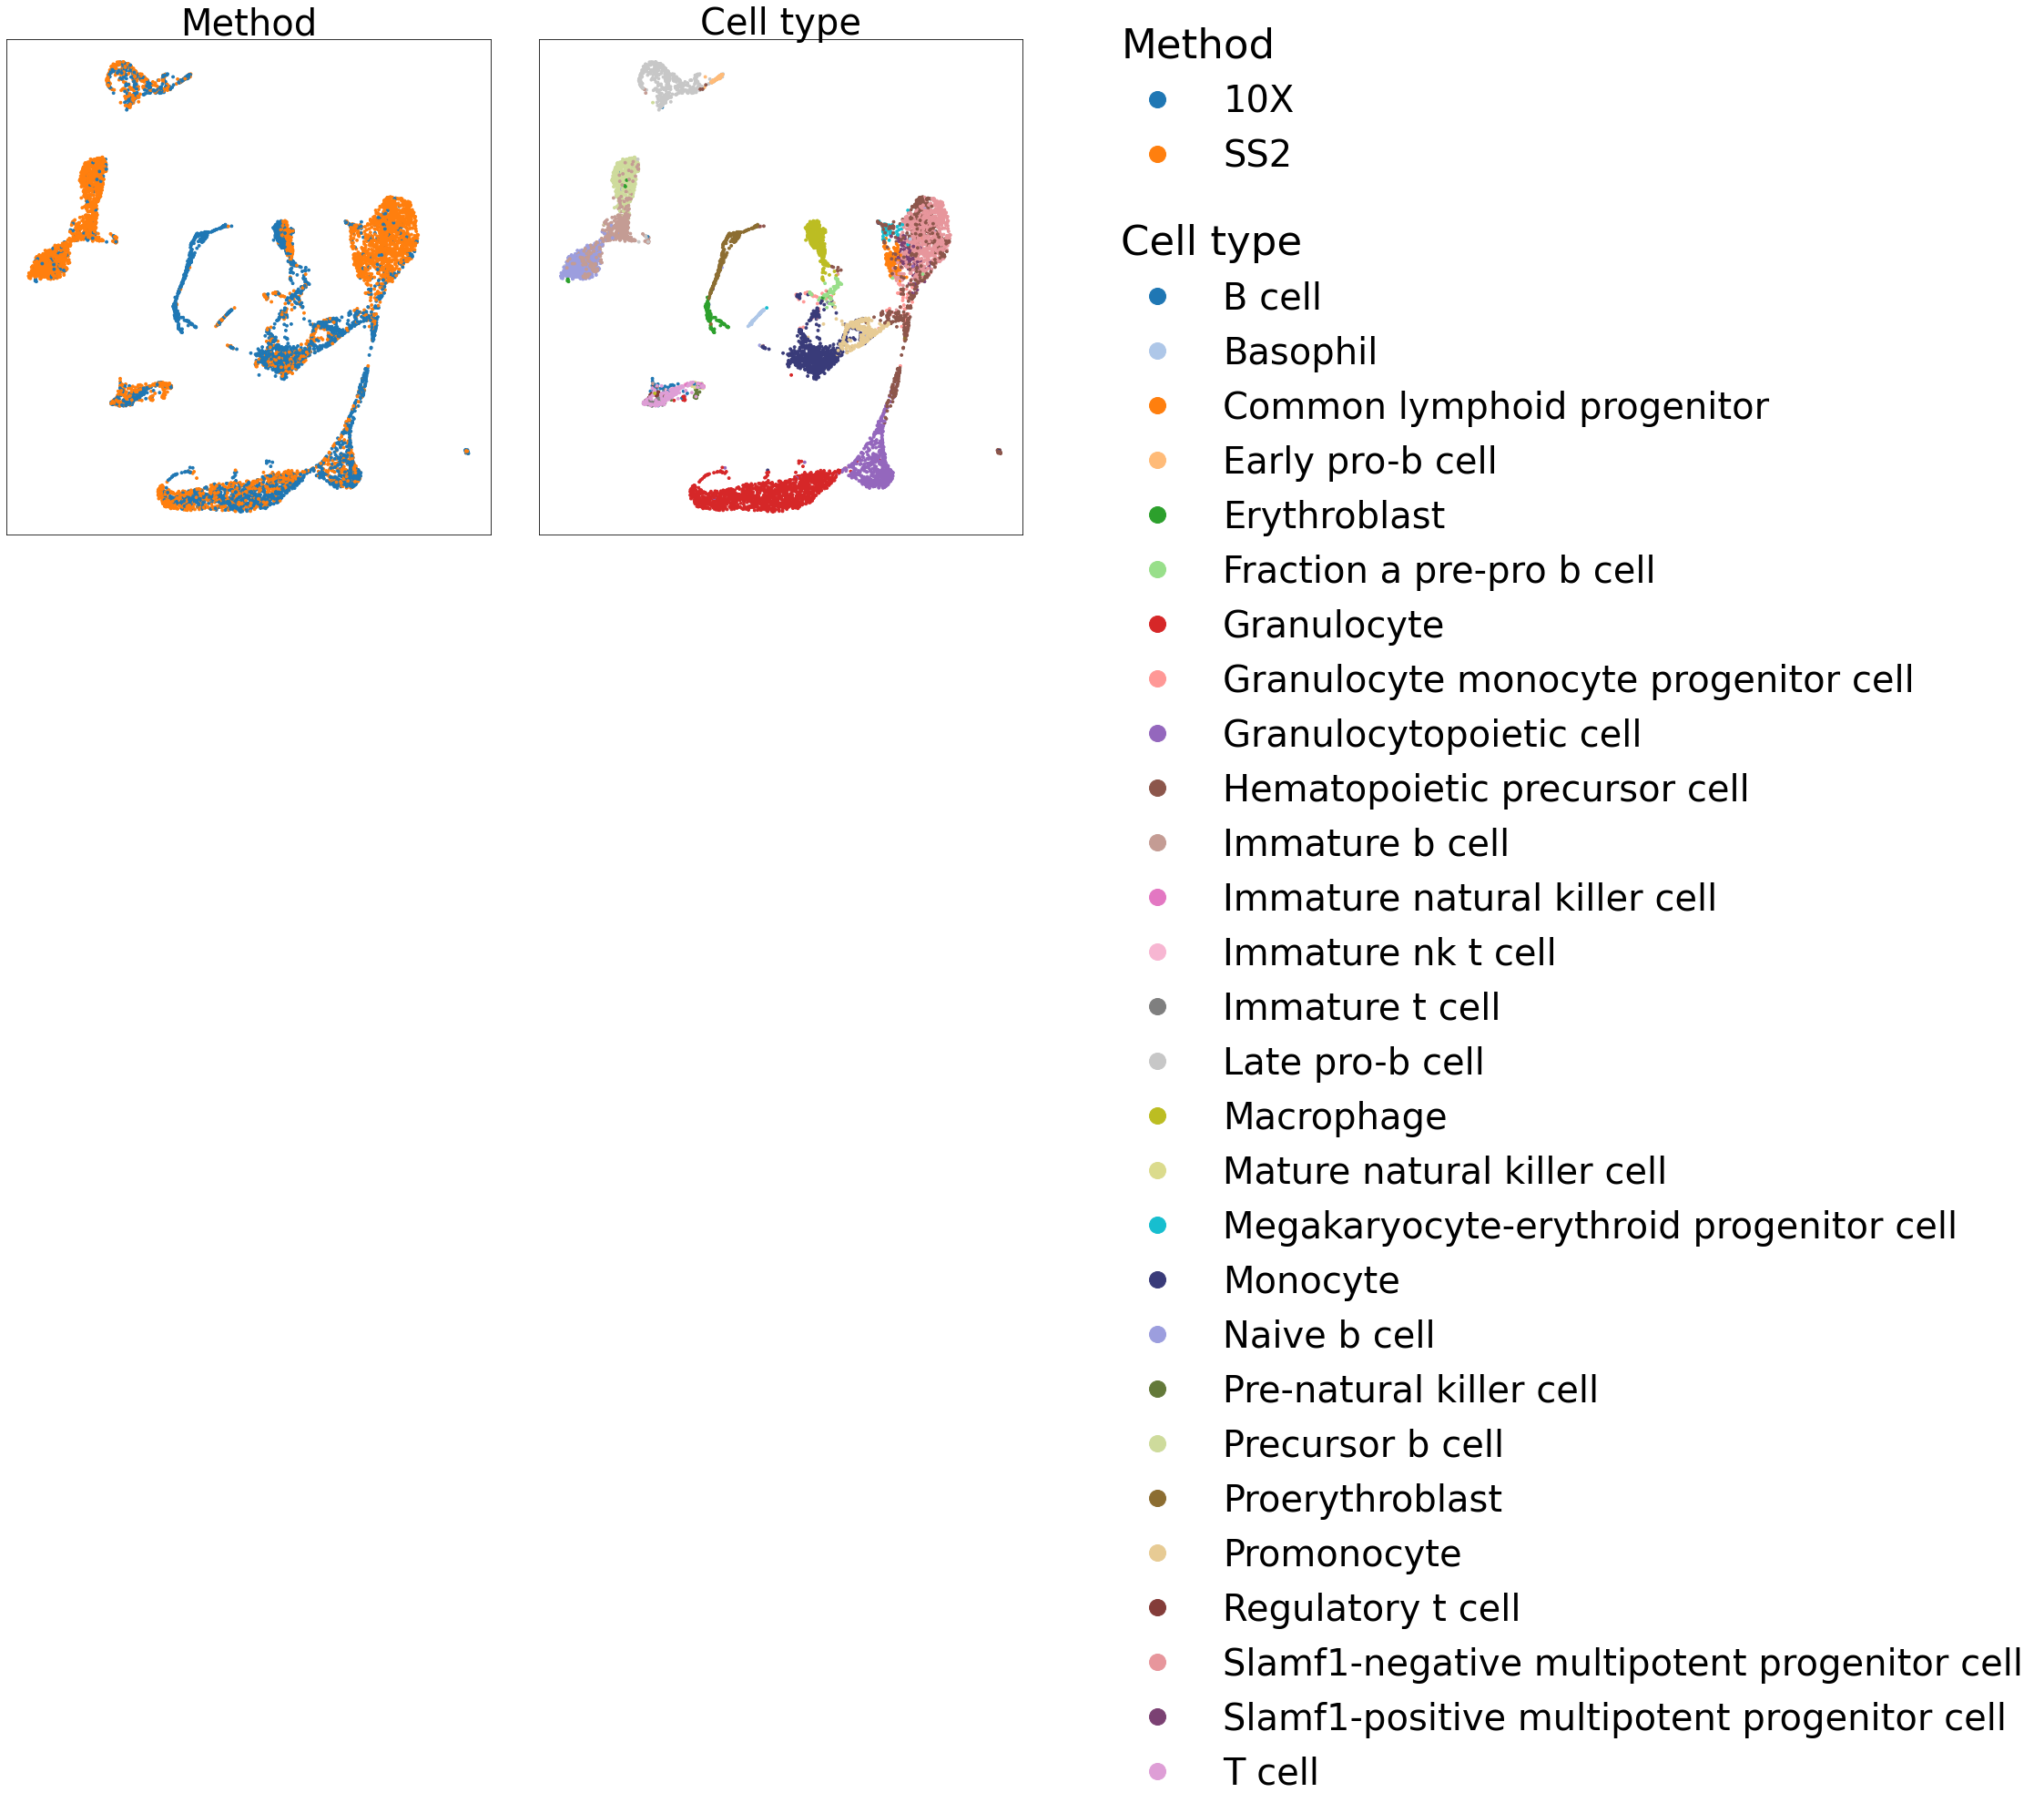

In [6]:
f = plt.figure(figsize=(20,10))

np.random.seed(1234)
order = np.arange(len(meta))
np.random.shuffle(order)

ax1 = f.add_subplot(1,2,1)

scatter1 = ax1.scatter(embedding[order, 0], embedding[order, 1], s=size, c=label[order], cmap=colours, label=meta["method"].values[order])
ax1.set_title("Method", fontsize=40)
ax1.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax2 = f.add_subplot(1,2,2)
scatter2 = ax2.scatter(embedding[:, 0], embedding[:, 1], s=size, c=label2, cmap=colours2, label=meta["celltype"].values)
ax2.set_title("Cell type", fontsize=40)
ax2.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
l1 = f.legend(handles=scatter1.legend_elements()[0], labels=sorted(set(meta["method"])), loc="upper left", bbox_to_anchor=(0.95, 0.95), 
                    markerscale=3., title_fontsize=45, fontsize=40, frameon=False, ncol=1, title="Method")
l2 = f.legend(handles=scatter2.legend_elements(num=len(sorted(set(meta["celltype"])))-1)[0], labels=sorted(set(meta["celltype"])), loc="upper left", bbox_to_anchor=(0.95, 0.65), 
                    markerscale=3., title_fontsize=45, fontsize=40, frameon=False, ncol=1, title="Cell type")
l1._legend_box.align = "left"
l2._legend_box.align = "left"

f.subplots_adjust(hspace=.1, wspace=.1)